In [10]:
# # Gaussian Splatting — View Synthesis from Checkpoint

# Load `checkpoints/splat_step2000.pt` and render novel views from multiple camera angles.

In [41]:
import sys, os, math, importlib
sys.path.insert(0, os.path.abspath(".."))

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Force reimport to pick up latest changes
import renderer.rendering as _rmod
importlib.reload(_rmod)

# Bind required symbols from renderer.rendering
Camera               = _rmod.Camera
GaussianParameters   = _rmod.GaussianParameters
compute_aspect_scales = _rmod.compute_aspect_scales
apply_aspect_correction = _rmod.apply_aspect_correction
render_mip_projection = _rmod.render_mip_projection
_orbit_pose           = _rmod._orbit_pose

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Original volume dimensions (Z, Y, X) — needed for aspect correction
VOL_SHAPE = (100, 647, 813)
aspect_scales = compute_aspect_scales(VOL_SHAPE)
print(f"Volume shape (Z,Y,X): {VOL_SHAPE}")
print(f"Aspect scales (x,y,z): {aspect_scales.tolist()}")
print(f"  X spans [-1.00, 1.00],  Y spans [-{aspect_scales[1]:.3f}, {aspect_scales[1]:.3f}],  Z spans [-{aspect_scales[2]:.3f}, {aspect_scales[2]:.3f}]")

Device: cuda
Volume shape (Z,Y,X): (100, 647, 813)
Aspect scales (x,y,z): [1.0, 0.7958179712295532, 0.12300123274326324]
  X spans [-1.00, 1.00],  Y spans [-0.796, 0.796],  Z spans [-0.123, 0.123]


In [55]:
# ── Load checkpoint ──────────────────────────────────────────
ckpt_path = './checkpoints/pipeline/checkpoint_step1500.pt'
ckpt = torch.load(ckpt_path, map_location=device)

means            = ckpt["means"].to(device)
log_scales       = ckpt["log_scales"].to(device)
quaternions      = ckpt["quaternions"].to(device)
log_intensities  = ckpt["log_intensities"].to(device)

print(f"Epoch {ckpt.get('epoch', '?')} — {means.shape[0]} Gaussians loaded")
print(f"  means:            {means.shape}")
print(f"  log_scales:       {log_scales.shape}")
print(f"  quaternions:      {quaternions.shape}")
print(f"  log_intensities:  {log_intensities.shape}")

Epoch ? — 9764 Gaussians loaded
  means:            torch.Size([9764, 3])
  log_scales:       torch.Size([9764, 3])
  quaternions:      torch.Size([9764, 4])
  log_intensities:  torch.Size([9764])


In [56]:
# ── Reconstruct GaussianParameters from checkpoint ──────────
K = means.shape[0]

# Scales: exp(log_scales), clamped
scales = torch.exp(log_scales).clamp(1e-5, 1e2)

# Quaternion → rotation matrix
q = F.normalize(quaternions, p=2, dim=-1)
w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]

R_mat = torch.zeros(K, 3, 3, device=device, dtype=q.dtype)
R_mat[:, 0, 0] = 1 - 2*(y*y + z*z)
R_mat[:, 0, 1] = 2*(x*y - w*z)
R_mat[:, 0, 2] = 2*(x*z + w*y)
R_mat[:, 1, 0] = 2*(x*y + w*z)
R_mat[:, 1, 1] = 1 - 2*(x*x + z*z)
R_mat[:, 1, 2] = 2*(y*z - w*x)
R_mat[:, 2, 0] = 2*(x*z - w*y)
R_mat[:, 2, 1] = 2*(y*z + w*x)
R_mat[:, 2, 2] = 1 - 2*(x*x + y*y)

# Σ = R diag(s²) Rᵀ
S2 = torch.diag_embed(scales ** 2)
covariances = R_mat @ S2 @ R_mat.transpose(-2, -1)

# log_intensities → intensities via sigmoid (matches MIPSplattingTrainer)
intensities = torch.sigmoid(log_intensities)

gaussians_raw = GaussianParameters(
    means=means,
    covariances=covariances,
    intensities=intensities,
)

# ── Apply aspect-ratio correction ───────────────────────────
gaussians = apply_aspect_correction(gaussians_raw, aspect_scales)

print(f"GaussianParameters ready: K={K}")
print(f"  Raw   means range:  x=[{means[:,0].min():.3f}, {means[:,0].max():.3f}]  "
      f"y=[{means[:,1].min():.3f}, {means[:,1].max():.3f}]  "
      f"z=[{means[:,2].min():.3f}, {means[:,2].max():.3f}]")
print(f"  Corrected range:    x=[{gaussians.means[:,0].min():.3f}, {gaussians.means[:,0].max():.3f}]  "
      f"y=[{gaussians.means[:,1].min():.3f}, {gaussians.means[:,1].max():.3f}]  "
      f"z=[{gaussians.means[:,2].min():.3f}, {gaussians.means[:,2].max():.3f}]")

GaussianParameters ready: K=9764
  Raw   means range:  x=[-1.581, 1.485]  y=[-1.684, 1.673]  z=[-1.672, 1.780]
  Corrected range:    x=[-1.581, 1.485]  y=[-1.340, 1.331]  z=[-0.206, 0.219]


In [57]:
# ── Render novel views ──────────────────────────────────────
H, W = 256, 256
camera = Camera.from_fov(fov_x_deg=50.0, width=W, height=H, near=0.01, far=10.0)

# Define viewpoints: 8 azimuths × 3 elevations
azimuths   = [0, 45, 90, 135, 180, 225, 270, 315]
elevations = [-30, 0, 30]
radius     = 1.5

images = []
labels = []

with torch.no_grad():
    for el in elevations:
        for az in azimuths:
            R_cam, T_cam = _orbit_pose(float(el), float(az), float(radius))
            R_cam = R_cam.to(device)
            T_cam = T_cam.to(device)
            img, n_vis = render_mip_projection(gaussians, camera, R_cam, T_cam)
            images.append(img.cpu().numpy())
            labels.append(f"el={el}° az={az}°")
            
print(f"Rendered {len(images)} views")

Rendered 24 views


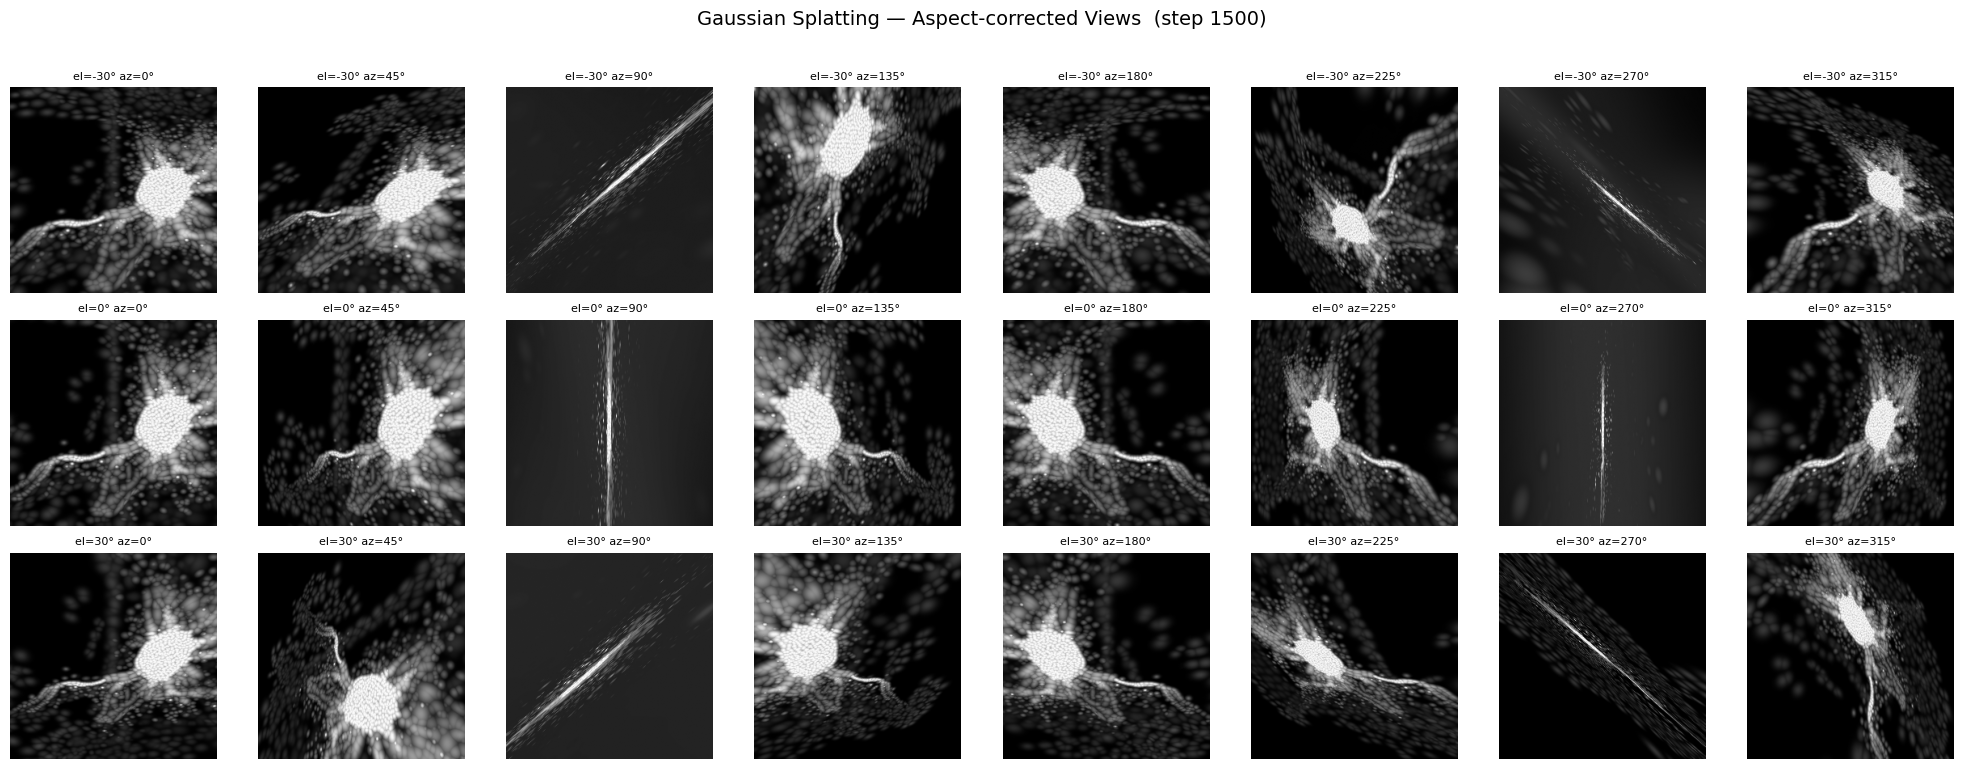

In [58]:
# ── Display synthesised views ───────────────────────────────
n_cols = len(azimuths)
n_rows = len(elevations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
fig.suptitle(f"Gaussian Splatting — Aspect-corrected Views  (step {ckpt.get('step','?')})", fontsize=14, y=1.02)

vmax = max(img.max() for img in images) or 1.0

for i, (img, label) in enumerate(zip(images, labels)):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    ax.imshow(img, cmap="gray", vmin=0, vmax=vmax)
    ax.set_title(label, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
# ── Diagnose scale statistics ────────────────────────────────
_scales = torch.exp(log_scales)
_amps = torch.exp(log_amplitudes.clamp(-10., 6.)).clamp(0., 1.)

print("=== Scale statistics ===")
print(f"  log_scales range: [{log_scales.min():.3f}, {log_scales.max():.3f}]")
print(f"  scales     range: [{_scales.min():.5f}, {_scales.max():.3f}]")
print(f"  scales     mean:  {_scales.mean():.4f},  median: {_scales.median():.4f}")
print(f"  scales > 0.1:     {(_scales > 0.1).sum().item()} / {_scales.numel()}")
print(f"  scales > 0.5:     {(_scales > 0.5).sum().item()} / {_scales.numel()}")
print()

# Per-Gaussian "effective radius" = max scale (largest σ)
_max_scale_per_gauss = _scales.max(dim=-1).values
print("=== Per-Gaussian max scale (largest σ) ===")
print(f"  range:  [{_max_scale_per_gauss.min():.5f}, {_max_scale_per_gauss.max():.3f}]")
print(f"  mean:   {_max_scale_per_gauss.mean():.4f}")
print(f"  median: {_max_scale_per_gauss.median():.4f}")
print(f"  > 0.1:  {(_max_scale_per_gauss > 0.1).sum().item()}")
print(f"  > 0.3:  {(_max_scale_per_gauss > 0.3).sum().item()}")
print()

print("=== Intensity statistics ===")
print(f"  range:  [{_amps.min():.4f}, {_amps.max():.4f}]")
print(f"  mean:   {_amps.mean():.4f},  median: {_amps.median():.4f}")
print(f"  > 0.5:  {(_amps > 0.5).sum().item()} / {_amps.numel()}")

# Bright + large = the bloated ones
_bright_large = (_max_scale_per_gauss > 0.1) & (_amps > 0.3)
print(f"\n  Bright (>0.3) AND large (σ>0.1): {_bright_large.sum().item()}")

# Histogram
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
axes[0].hist(_scales.cpu().numpy().ravel(), bins=100, log=True)
axes[0].set_title("All scales (3 per Gaussian)")
axes[0].set_xlabel("scale (σ)")
axes[1].hist(_max_scale_per_gauss.cpu().numpy(), bins=100, log=True)
axes[1].set_title("Max scale per Gaussian")
axes[1].set_xlabel("max σ")
axes[2].hist(_amps.cpu().numpy(), bins=100, log=True)
axes[2].set_title("Intensities")
axes[2].set_xlabel("amplitude")
plt.tight_layout()
plt.show()

NameError: name 'log_amplitudes' is not defined

In [ ]:
# ── Load step-10000 checkpoint for interactive rendering ─────
ckpt_10k = torch.load(os.path.join("..", "checkpoints", "splat_step10000.pt"), map_location=device)

_means = ckpt_10k["means"].to(device)
_log_scales = ckpt_10k["log_scales"].to(device)
_quats = ckpt_10k["quaternions"].to(device)
_log_amps = ckpt_10k["log_amplitudes"].to(device)

_K = _means.shape[0]
_scales = torch.exp(_log_scales).clamp(1e-5, 1e2)
_q = F.normalize(_quats, p=2, dim=-1)
_w, _x, _y, _z = _q[:,0], _q[:,1], _q[:,2], _q[:,3]
_R = torch.zeros(_K, 3, 3, device=device, dtype=_q.dtype)
_R[:,0,0]=1-2*(_y*_y+_z*_z); _R[:,0,1]=2*(_x*_y-_w*_z); _R[:,0,2]=2*(_x*_z+_w*_y)
_R[:,1,0]=2*(_x*_y+_w*_z);   _R[:,1,1]=1-2*(_x*_x+_z*_z); _R[:,1,2]=2*(_y*_z-_w*_x)
_R[:,2,0]=2*(_x*_z-_w*_y);   _R[:,2,1]=2*(_y*_z+_w*_x);   _R[:,2,2]=1-2*(_x*_x+_y*_y)
_S2 = torch.diag_embed(_scales ** 2)
_cov = _R @ _S2 @ _R.transpose(-2, -1)
_amps = torch.exp(_log_amps.clamp(-10., 6.)).clamp(0., 1.)
_g_raw = GaussianParameters(means=_means, covariances=_cov, intensities=_amps)
gaussians_10k = apply_aspect_correction(_g_raw, aspect_scales)

print(f"Loaded step {ckpt_10k.get('step','?')} — {_K} Gaussians (aspect-corrected)")

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/splat_step10000.pt'

In [ ]:
# ── Pre-render orbit cache for real-time interactive viewer ───
import time, io
from PIL import Image as PILImage
import ipywidgets as widgets
from IPython.display import display

# Render settings
_H, _W = 256, 256
_cam = Camera.from_fov(fov_x_deg=50.0, width=_W, height=_H, near=0.01, far=10.0)

# Dense orbit grid: 72 azimuths (5° step) × 7 elevations × 5 radii
_azimuths_cache   = list(range(0, 360, 5))       # 72 values
_elevations_cache = [-60, -40, -20, 0, 20, 40, 60]  # 7 values
_radii_cache      = [1.5, 2.0, 2.5, 3.0, 4.0]        # 5 values

print(f"Pre-rendering {len(_azimuths_cache)}×{len(_elevations_cache)}×{len(_radii_cache)} "
      f"= {len(_azimuths_cache)*len(_elevations_cache)*len(_radii_cache)} frames "
      f"at {_W}×{_H}...")
t0 = time.time()

_frame_cache = {}

with torch.no_grad():
    total = len(_elevations_cache) * len(_azimuths_cache) * len(_radii_cache)
    done = 0
    for ri, rad in enumerate(_radii_cache):
        for ei, el in enumerate(_elevations_cache):
            for ai, az in enumerate(_azimuths_cache):
                Rc, Tc = _orbit_pose(float(el), float(az), float(rad))
                Rc, Tc = Rc.to(device), Tc.to(device)
                img, _ = render_mip_projection(gaussians_10k, _cam, Rc, Tc)
                _frame_cache[(ei, ai, ri)] = img.cpu().numpy()
                done += 1
        print(f"  {done}/{total} frames ({done*100//total}%)")

elapsed = time.time() - t0
print(f"Cache ready: {len(_frame_cache)} frames in {elapsed:.1f}s "
      f"({elapsed/len(_frame_cache)*1000:.1f}ms/frame)")
# Pre-compute the global vmax across all frames for consistent brightness
_global_vmax = max(f.max() for f in _frame_cache.values())
if _global_vmax == 0:
    _global_vmax = 1.0
print(f"Global vmax: {_global_vmax:.4f}")

Pre-rendering 72×7×5 = 2520 frames at 256×256...


NameError: name 'gaussians_10k' is not defined

In [ ]:
# ── WebGL real-time viewer (Three.js Gaussian splats) ────────
import json, base64, struct, http.server, threading

# Extract data from the already-loaded aspect-corrected Gaussians
_g = gaussians_10k
_pos   = _g.means.detach().cpu().numpy().astype(np.float32)      # (K, 3)
_wt    = _g.intensities.detach().cpu().numpy().astype(np.float32) # (K,)
_cov3d = _g.covariances.detach().cpu().numpy().astype(np.float32) # (K, 3, 3)

# Compute per-Gaussian billboard "size" from eigenvalues of covariance
_eigvals = np.linalg.eigvalsh(_cov3d)                             # (K, 3), sorted ascending
_max_sigma = np.sqrt(np.maximum(_eigvals[:, -1], 1e-12))
_sizes = (_max_sigma * 6.0).astype(np.float32)
print(f"Size stats: min={_sizes.min():.4f}, max={_sizes.max():.4f}, mean={_sizes.mean():.4f}, median={np.median(_sizes):.4f}")

# Filter out very dim Gaussians for performance
_mask = _wt > 0.01
_pos_f   = _pos[_mask]
_wt_f    = _wt[_mask]
_sizes_f = _sizes[_mask]
n_pts = _pos_f.shape[0]
print(f"WebGL viewer: {n_pts} Gaussians (filtered from {_pos.shape[0]}, threshold=0.01)")

# Pack binary: [x, y, z, size, alpha] × N  (5 float32 per point = 20 bytes)
_buf = np.column_stack([_pos_f, _sizes_f, _wt_f]).astype(np.float32)
_b64 = base64.b64encode(_buf.tobytes()).decode('ascii')

# Scene bounding box for camera setup
_bmin = _pos_f.min(axis=0)
_bmax = _pos_f.max(axis=0)
_center = ((_bmin + _bmax) / 2).tolist()
_extent = float(np.linalg.norm(_bmax - _bmin))
print(f"  Bounds: [{_bmin[0]:.2f},{_bmin[1]:.2f},{_bmin[2]:.2f}] → [{_bmax[0]:.2f},{_bmax[1]:.2f},{_bmax[2]:.2f}]")
print(f"  Extent: {_extent:.2f}")

html_content = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8">
<title>NeuroGS WebGL Viewer</title>
<style>
  body {{ margin:0; overflow:hidden; background:#000; font-family:monospace; }}
  #info {{ position:absolute; top:8px; left:8px; color:#aaa; font-size:12px; z-index:10;
           background:rgba(0,0,0,0.6); padding:6px 10px; border-radius:4px; }}
  #info b {{ color:#fff; }}
  canvas {{ display:block; }}
</style>
</head><body>
<div id="info">
  <b>NeuroGS Gaussian Splat Viewer</b> — {n_pts} Gaussians (step 10000)<br>
  Drag to orbit · Scroll to zoom · Right-drag to pan
</div>

<script src="https://cdn.jsdelivr.net/npm/three@0.160.0/build/three.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/three@0.160.0/examples/js/controls/OrbitControls.js"></script>
<script>
const N = {n_pts};
const CENTER = {json.dumps(_center)};
const EXTENT = {_extent:.4f};

// Decode binary data
const raw = atob("{_b64}");
const ab = new ArrayBuffer(raw.length);
const u8 = new Uint8Array(ab);
for (let i = 0; i < raw.length; i++) u8[i] = raw.charCodeAt(i);
const f32 = new Float32Array(ab);  // N * 5 floats: x,y,z,size,alpha

// Scene
const scene = new THREE.Scene();
scene.background = new THREE.Color(0x000000);

// Camera
const camera = new THREE.PerspectiveCamera(50, window.innerWidth/window.innerHeight, 0.01, 100);
camera.position.set(CENTER[0], CENTER[1] + EXTENT*0.3, CENTER[2] + EXTENT*1.2);
camera.lookAt(CENTER[0], CENTER[1], CENTER[2]);

// Renderer
const renderer = new THREE.WebGLRenderer({{ antialias: true }});
renderer.setPixelRatio(window.devicePixelRatio);
renderer.setSize(window.innerWidth, window.innerHeight);
document.body.appendChild(renderer.domElement);

// Controls
const controls = new THREE.OrbitControls(camera, renderer.domElement);
controls.target.set(CENTER[0], CENTER[1], CENTER[2]);
controls.enableDamping = true;
controls.dampingFactor = 0.12;
controls.rotateSpeed = 0.8;
controls.minDistance = 0.1;
controls.maxDistance = EXTENT * 5;
controls.update();

// Build point cloud with per-point size & alpha
const positions = new Float32Array(N * 3);
const sizes     = new Float32Array(N);
const alphas    = new Float32Array(N);

for (let i = 0; i < N; i++) {{
  const off = i * 5;
  positions[i*3]     = f32[off];
  positions[i*3 + 1] = f32[off + 1];
  positions[i*3 + 2] = f32[off + 2];
  sizes[i]   = f32[off + 3];
  alphas[i]  = f32[off + 4];
}}

const geom = new THREE.BufferGeometry();
geom.setAttribute('position', new THREE.BufferAttribute(positions, 3));
geom.setAttribute('aSize',    new THREE.BufferAttribute(sizes, 1));
geom.setAttribute('aAlpha',   new THREE.BufferAttribute(alphas, 1));

// Gaussian billboard shader — MIP blending (max intensity projection)
const material = new THREE.ShaderMaterial({{
  transparent: true,
  depthWrite: false,
  blending: THREE.CustomBlending,
  blendEquation: THREE.MaxEquation,
  blendSrc: THREE.OneFactor,
  blendDst: THREE.OneFactor,
  uniforms: {{
    uScale: {{ value: 1500.0 }},
  }},
  vertexShader: `
    attribute float aSize;
    attribute float aAlpha;
    varying float vAlpha;
    uniform float uScale;
    void main() {{
      vAlpha = pow(clamp(aAlpha, 0.0, 1.0), 0.3);
      vec4 mvPos = modelViewMatrix * vec4(position, 1.0);
      gl_PointSize = uScale * aSize / -mvPos.z;
      gl_PointSize = clamp(gl_PointSize, 2.0, 1024.0);
      gl_Position = projectionMatrix * mvPos;
    }}
  `,
  fragmentShader: `
    varying float vAlpha;
    void main() {{
      vec2 uv = gl_PointCoord - 0.5;
      float r2 = dot(uv, uv);
      float g = exp(-r2 / 0.18);
      if (g < 0.003) discard;
      float intensity = vAlpha * g * 2.0;
      gl_FragColor = vec4(intensity, intensity, intensity, 1.0);
    }}
  `,
}});

const points = new THREE.Points(geom, material);
scene.add(points);

const grid = new THREE.GridHelper(EXTENT * 2, 20, 0x333333, 0x222222);
grid.position.set(CENTER[0], CENTER[1] - EXTENT * 0.5, CENTER[2]);
scene.add(grid);

let frameCount = 0, lastTime = performance.now(), fpsText = '';
const infoEl = document.getElementById('info');

function animate() {{
  requestAnimationFrame(animate);
  controls.update();
  renderer.render(scene, camera);
  
  frameCount++;
  const now = performance.now();
  if (now - lastTime > 500) {{
    fpsText = (frameCount / ((now - lastTime) / 1000)).toFixed(0);
    frameCount = 0;
    lastTime = now;
    infoEl.innerHTML = '<b>NeuroGS Gaussian Splat Viewer</b> — {n_pts} Gaussians (step 10000)' +
      '<br>Drag to orbit · Scroll to zoom · Right-drag to pan' +
      '<br><b>' + fpsText + ' FPS</b>';
  }}
}}
animate();

window.addEventListener('resize', () => {{
  camera.aspect = window.innerWidth / window.innerHeight;
  camera.updateProjectionMatrix();
  renderer.setSize(window.innerWidth, window.innerHeight);
}});
</script>
</body></html>
"""

# Write HTML file
_viewer_path = os.path.abspath("webgl_viewer.html")
with open(_viewer_path, "w") as f:
    f.write(html_content)
print(f"Wrote {len(html_content)//1024}KB → {_viewer_path}")

# Start a simple HTTP server from the workspace root
_PORT = 8765
_serve_dir = os.path.abspath("..")

class _QuietHandler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=_serve_dir, **kwargs)
    def log_message(self, format, *args): pass

try:
    _httpd = http.server.HTTPServer(("0.0.0.0", _PORT), _QuietHandler)
    threading.Thread(target=_httpd.serve_forever, daemon=True).start()
    print(f"HTTP server on port {_PORT} (serving {_serve_dir})")
except OSError:
    print(f"Port {_PORT} already in use (server likely running from previous run)")

_url = f"http://localhost:{_PORT}/rendering/webgl_viewer.html"
print(f"Viewer URL: {_url}")

Size stats: min=0.0059, max=1.6455, mean=0.1071, median=0.0691
WebGL viewer: 10478 Gaussians (filtered from 12145, threshold=0.01)
  Bounds: [-1.00,-0.80,-0.12] → [1.00,0.80,0.12]
  Extent: 2.57
Wrote 277KB → /workspace/neurogs/neurogs_v7/rendering/webgl_viewer.html
Port 8765 already in use (server likely running from previous run)
Viewer URL: http://localhost:8765/rendering/webgl_viewer.html


In [ ]:
# ── Display WebGL viewer inline + open in Simple Browser ─────
from IPython.display import display, HTML

display(HTML(f"""
<div style="border:1px solid #444; border-radius:4px; overflow:hidden;">
  <iframe src="{_url}" 
          width="100%" height="700" frameborder="0"
          style="background:#000;">
  </iframe>
</div>
<p style="color:#888; font-size:12px; margin:4px 0;">
  ↑ Interactive WebGL viewer — drag to orbit, scroll to zoom, right-drag to pan at 60 FPS.<br>
  For full-screen: open <a href="{_url}" target="_blank">{_url}</a>
</p>
"""))

NameError: name '_url' is not defined